In [1]:
import numpy as np
import pickle
import os
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === 1. Load Real Preprocessed Data ===
X_all_normalized = np.load('preprocessed_data/X_all_normalized.npy')
with open('preprocessed_data/sym_all.pkl', 'rb') as f:
    sym_all = pickle.load(f)

In [2]:
# === 2. Map Beat Symbols to Class Indices ===
unique_classes = sorted(set(sym_all))
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
num_classes = len(unique_classes)

# Create y_all as integer class labels
y_all = np.array([label_to_index[sym] for sym in sym_all])

In [3]:
def load_and_append_synthetic(X_real, y_real, synth_map, label_to_index, base_path=''):
    """
    Load synthetic data and append it to the real dataset.

    Parameters:
        X_real (np.ndarray): Real ECG data.
        y_real (np.ndarray): Real labels (int format).
        synth_map (dict): Dictionary of class_label: filename.
        label_to_index (dict): Mapping from label to integer index.
        base_path (str): Optional base directory for synthetic files.

    Returns:
        X_combined (np.ndarray), y_combined (np.ndarray)
    """
    X_synth_list = []
    y_synth_list = []

    for label, filename in synth_map.items():
        path = os.path.join(base_path, filename)
        if os.path.exists(path):
            print(f"Loading synthetic data for class '{label}' from {filename}")
            X_synth = np.load(path)
            y_synth = np.full((X_synth.shape[0],), label_to_index[label])
            X_synth_list.append(X_synth)
            y_synth_list.append(y_synth)
        else:
            print(f"Warning: File {filename} not found. Skipping class '{label}'.")

    if X_synth_list:
        X_synth_all = np.vstack(X_synth_list)
        y_synth_all = np.concatenate(y_synth_list)
        X_combined = np.vstack([X_real, X_synth_all])
        y_combined = np.concatenate([y_real, y_synth_all])
    else:
        print("No synthetic files were successfully loaded.")
        X_combined, y_combined = X_real, y_real

    return X_combined, y_combined


In [4]:
# === 3. Load the Generated Class Samples ===

# Synthetic file mapping
synthetic_files = {
    # Sample size < 10
    'S': 'generated_S_signals.npy',

    # 10 < Sample size < 7000
    'J': 'generated_JJ_signals.npy',
    'A': 'generated_AA_signals.npy',
    'e': 'generated_e_signals.npy',
    'f': 'generated_f_signals.npy',
    'F': 'generated_FF_signals.npy',
    'j': 'generated_j_signals.npy',
    # '/': 'generated_o_signals.npy',
    # 'R': 'generated_R_signals.npy',
    # 'V': 'generated_V_signals.npy',
    'E': 'generated_EE_signals.npy',
    'a': 'generated_a_signals.npy',
}


# === 4. Combine Real + Synthetic Data ===
X_combined, y_combined = load_and_append_synthetic(X_all_normalized, y_all, synthetic_files, label_to_index, base_path='generated_data')


Loading synthetic data for class 'S' from generated_S_signals.npy
Loading synthetic data for class 'J' from generated_JJ_signals.npy
Loading synthetic data for class 'A' from generated_AA_signals.npy
Loading synthetic data for class 'e' from generated_e_signals.npy
Loading synthetic data for class 'f' from generated_f_signals.npy
Loading synthetic data for class 'F' from generated_FF_signals.npy
Loading synthetic data for class 'j' from generated_j_signals.npy
Loading synthetic data for class 'E' from generated_EE_signals.npy
Loading synthetic data for class 'a' from generated_a_signals.npy


In [5]:
X_combined.shape

(176194, 2160)

In [6]:
# === 5. Shuffle the Dataset ===
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

In [7]:
# === 6. Reshape for Conv1D (add channel dimension) ===
X_combined = X_combined[..., np.newaxis]  # shape becomes (samples, 1080, 1)

# === 7. One-Hot Encode Labels ===
y_combined_categorical = to_categorical(y_combined, num_classes=num_classes)

In [8]:
# === 8. Split into Train and Validation Sets (optional) ===
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined_categorical, test_size=0.2, random_state=42)

In [9]:
total_samples = X_combined.shape[0]
train_samples = X_train.shape[0]
test_samples = X_val.shape[0]

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples:.2%})")
print(f"Testing samples: {test_samples} ({test_samples / total_samples:.2%})")

Total samples: 176194
Training samples: 140955 (80.00%)
Testing samples: 35239 (20.00%)


In [10]:
from collections import Counter
# Decode one-hot encoded labels back to class indices
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Count samples per class
train_class_counts = Counter(y_train_labels)
val_class_counts = Counter(y_val_labels)

# Map indices back to class labels (optional)
index_to_label = {v: k for k, v in label_to_index.items()}

# Print results
print("=== Training Set Class Distribution ===")
for idx, count in sorted(train_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")

print("\n=== Validation Set Class Distribution ===")
for idx, count in sorted(val_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")

=== Training Set Class Distribution ===
Class / (index 0): 5603 samples
Class A (index 1): 6450 samples
Class E (index 2): 6367 samples
Class F (index 3): 6361 samples
Class J (index 4): 6369 samples
Class L (index 5): 6419 samples
Class N (index 6): 59918 samples
Class R (index 7): 5737 samples
Class S (index 8): 6477 samples
Class V (index 9): 5714 samples
Class a (index 10): 6347 samples
Class e (index 11): 6386 samples
Class f (index 12): 6396 samples
Class j (index 13): 6411 samples

=== Validation Set Class Distribution ===
Class / (index 0): 1396 samples
Class A (index 1): 1550 samples
Class E (index 2): 1633 samples
Class F (index 3): 1639 samples
Class J (index 4): 1631 samples
Class L (index 5): 1633 samples
Class N (index 6): 14877 samples
Class R (index 7): 1498 samples
Class S (index 8): 1523 samples
Class V (index 9): 1399 samples
Class a (index 10): 1653 samples
Class e (index 11): 1614 samples
Class f (index 12): 1604 samples
Class j (index 13): 1589 samples


In [11]:
# === 9. Define Your CNN Model ===
model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-26 22:35:33.623030: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-26 22:35:33.623459: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-26 22:35:33.623474: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-26 22:35:33.623515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 22:35:33.623959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2154, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1077, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1073, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 536, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 534, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 267, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68352)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,749,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,891,150 (33.92 MB)

 Trainable params: 8,891,150 (33.92 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import time
# Start timer
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val)
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15


2025-05-26 22:35:36.614318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1102/1102 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.7009 - loss: 2.6111 - val_accuracy: 0.8041 - val_loss: 0.7990
Epoch 2/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 105s 95ms/step - accuracy: 0.7868 - loss: 1.4331 - val_accuracy: 0.8041 - val_loss: 0.7889
Epoch 3/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 103s 94ms/step - accuracy: 0.7955 - loss: 0.9804 - val_accuracy: 0.8041 - val_loss: 1.6901
Epoch 4/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 103s 93ms/step - accuracy: 0.7909 - loss: 1.2029 - val_accuracy: 0.8041 - val_loss: 0.9480
Epoch 5/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 103s 94ms/step - accuracy: 0.7956 - loss: 0.9375 - val_accuracy: 0.8041 - val_loss: 0.7860
Epoch 6/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 103s 94ms/step - accuracy: 0.8061 - loss: 0.7640 - val_accuracy: 0.8041 - val_loss: 0.7388
Epoch 7/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 104s 94ms/step - accuracy: 0.8048 - loss: 0.7479 - val_accuracy: 0.8041 - val_loss: 0.7379
Epoch 8/15
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 103s 94ms/step - accuracy: 0.8062 - lo

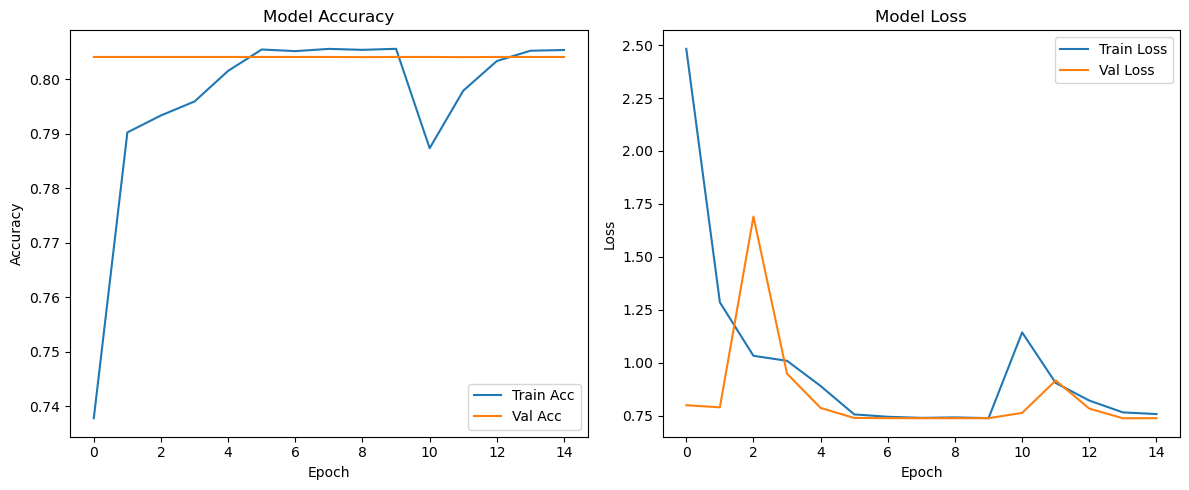

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

1102/1102 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step

📊 Evaluation Metrics:
Accuracy  : 0.8041
Precision : 0.6916
Recall    : 0.6702
F1-score  : 0.6760


/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1396
           1     1.0000    0.6755    0.8063      1550
           2     1.0000    0.9878    0.9938      1633
           3     1.0000    0.9036    0.9494      1639
           4     1.0000    0.9939    0.9969      1631
           5     0.0000    0.0000    0.0000      1633
           6     0.6830    1.0000    0.8117     14877
           7     0.0000    0.0000    0.0000      1498
           8     1.0000    1.0000    1.0000      1523
           9     0.0000    0.0000    0.0000      1399
          10     1.0000    0.9794    0.9896      1653
          11     1.0000    0.9988    0.9994      1614
          12     1.0000    0.8759    0.9339      1604
          13     1.0000    0.9673    0.9834      1589

    accuracy                         0.8041     35239
   macro avg     0.6916    0.6702    0.6760     35239
weighted avg     0.6980    0.8041    0.7367    

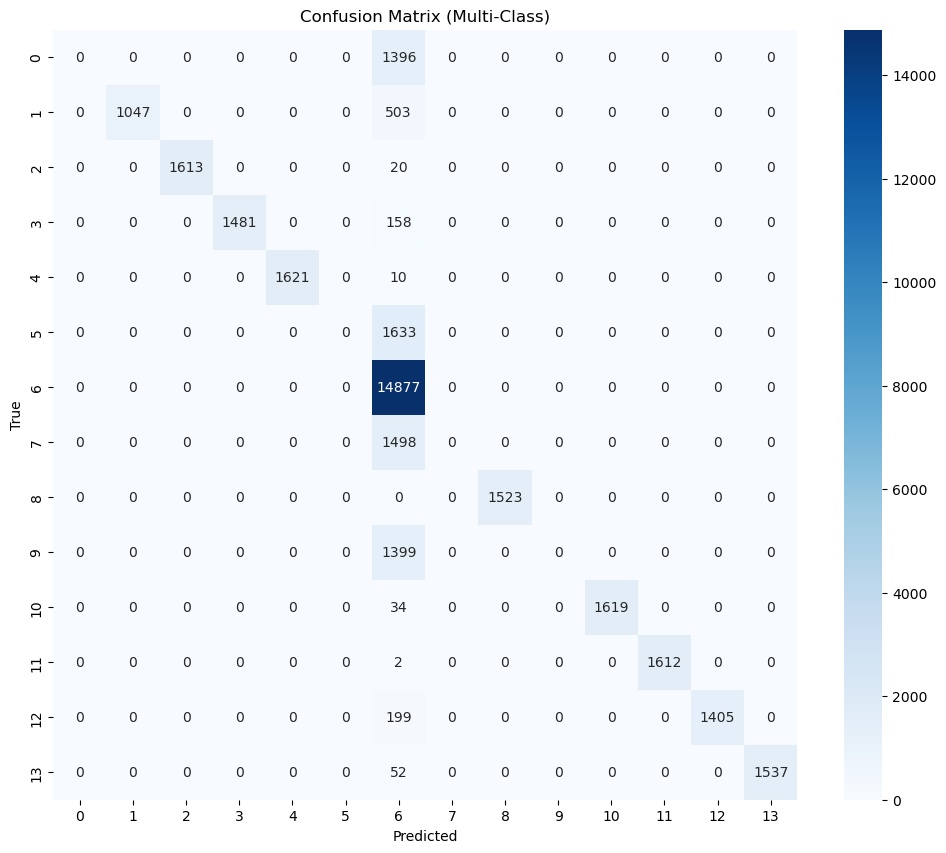

In [16]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

/var/folders/vy/h0yt7lx97b5ct5kp84j7dk_40000gn/T/ipykernel_3546/2714331143.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')


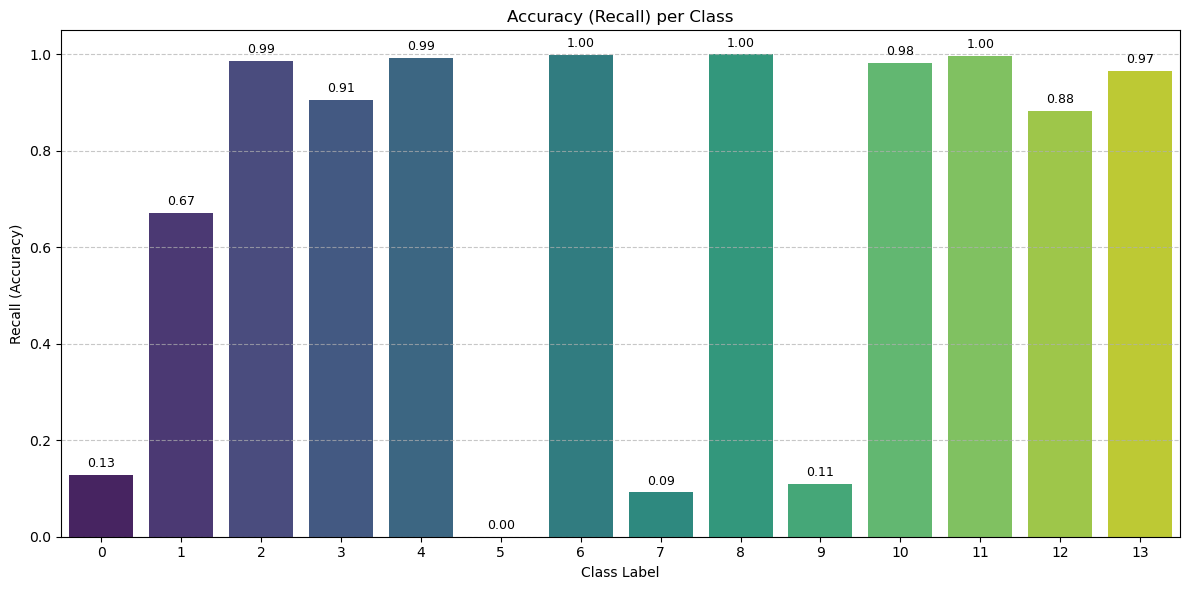

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.1282,0.6721,0.9870,0.9057,0.9931,0.0000,0.9997,0.0920,1.0000,0.1095,0.9820,0.9969,0.8828,0.9665
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
